# Tricky Functions and Cautionary Tales

Great, so you've now learned how to solve optimization problems with nonlinear objectives and nonlinear constraints by using overloaded expressions. To review:

* You can use `+, -, *, /, **,` etc. for typical arithmetic operations.

* For more complicated expressions like $\sin()$, $\log()$, etc., you can:

    1. `import aerosandbox.numpy as np`

    2. Proceed to use overloaded NumPy-like expressions: `np.sin(x)`, `np.log(x)`, etc.


**But wait!** We can't set you loose on the whole wide world of mathematical optimization just yet! We're actually in a
bit of a dangerous place here - we've given you just enough information to potentially get yourself into a real
pickle if you're not careful.

This is because nonlinear functions can present some real challenges if you're not aware of what you're doing. So, let's fix that by talking about some considerations:

-----

## Consideration 1: Differentiability (Minimizing $|x|$)

Let's give a very simple example:

Suppose we want to find the value of $x$ that minimizes $|x|$. Seems like a simple enough problem.

NumPy (and `aerosandbox.numpy`, by extension) provides us with the `np.fabs()` ("floating absolute value") function that lets us accomplish this:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

opti = asb.Opti()

x = opti.variable(init_guess=1)

opti.minimize(np.fabs(x))

Great! This seems easy enough to set up. But let's try to solve it...

(Spoiler, this will throw an error, hence we wrap it in a try/except block in order to catch it)

In [2]:
try:
    sol = opti.solve() # This is going to fail to solve and raise a RuntimeError
except RuntimeError as e:
    print(e)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

Whoa! Hang on, why did this fail to solve? The problem looked so easy - so easy, in fact, that we can identify the solution
just by inspection: `x = 0`!

We'll talk about what happened here, but first let me interject a quick tip about how to view the latest value of variables when the solver failed:

In [3]:
x_current = opti.debug.value(x) # Gets the last value of x before the solver failed
print(f"x_current = {x_current}")

x_current = 1.084681343854761e-06


This can be a useful trick to see where in the design space the solver was when it failed - this can give you a hint about what went wrong or what constraint you forgot to consider.

But let's return to the issue at hand - what's going on here? Why can't our solver find the minimum of $|x|$?

-----

Well, let's think about this from the perspective of the optimizer:

The optimizer we're using here is IPOPT, which is what's known as a second-order optimizer. This means that as it explores the design space, it's constructing a quadratic representation of the design space. (This representation is deliberately approximate, for reasons beyond scope here, but the general idea still applies.)

For our function $f(x) = |x|$, we can think about a few regions:
* For $x > 0$, we can approximate $f$ as $f(x) = x$. This is a straight line, which is a degenerate form of a quadratic function, so it fits into our representation.
* For $x < 0$, we can approximate $f$ as $f(x) = -x$. This is a straight line too, so we're good.

At $x = 0$, however, it's not clear what our quadratic approximation should look like. We remember from algebra class that we can fit a 1D quadratic function to three points, so we could try to fit a quadratic to the points in form $(x, f(x))$: $(-\epsilon, \epsilon)$, $(0, 0)$, and $(\epsilon, \epsilon)$ for some really tiny value of $\epsilon$. However in the limit of $\epsilon \rightarrow 0$, the quadratic coefficient in our function ends up going to infinity! So there is no finite quadratic representation of this function at $x=0$, and the optimizer freaks out.

From this, we can construct a good rule of thumb:

**If your objective function and constraints are not $C_1$-continuous (meaning they are continuous and have a continuous first derivative), you might have a bad time.**

Note that this isn't a hard rule:
* You can get away with non-$C_1$-continuous functions, so long as the optimizer stays away from discontinuities (roughly speaking, this means the initial point and optimal point are both far from the discontinuity.)
* You could still have trouble solving a problem with all-$C_1$-continuous functions, perhaps if the problem is poorly-scaled (we'll talk about this later).

(Note that for the rest of this section, we'll use "continuous" to mean $C_1$-continuous, and we'll use "discontinuous" to mean $C_1$-discontinuous.)

## Fixing Differentiability

But let's say the problem we want to solve truly does involve minimizing $|x|$ - how can we solve this?

I'm glad you asked! There are a few ways:

### Solution 1: Rewrite the Problem

Often, we can simply rewrite the problem in a way that doesn't use discontinuous functions, and we'll be good to go. This is the best path, if we can do it.

Recall that our problem before was:

* With decision variable $x$
* minimize $|x|$

Let's instead rewrite it as:

* With decision variables $x, y$
* minimize $y$
* subject to:
    * $y \geq x$
    * $y \geq -x$

Basically, we've broken our single discontinuous function into two linear constraints. Let's try solving it:

In [4]:
opti = asb.Opti()

x = opti.variable(init_guess=1)
y = opti.variable(init_guess=1)

opti.minimize(y)

opti.subject_to([
    y >= x,
    y >= -x
])

sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

The optimizer is super happy, and we got a solution! What is it?

In [5]:
print(f"x = {sol.value(x)}")

x = 6.092843768608933e-10


Our optimum is at $x=0$, just as we'd expect.

Whenever it's possible to use this piecewise-constraint approach we just described where we construct an auxiliary variable, we should use that. However, this isn't always possible - to speak precisely, it's not possible whenever our problem is nonconvex at the discontinuity itself. An example of this might be if someone told you to minimize the following function:

$
f(x) =
\begin{cases}
-x & \text{for } x < 0\\
(x-1)^2-1 & \text{for } x \geq 0\\
\end{cases}
$

In cases like this, we need to turn to other methods.

### Solution 2: Construct a Continuous Approximation

Another possible solution is to rewrite a discontinuous problem by approximating it with continuous functions. Note that, unlike the approach above, this is *actually changing* the optimization problem, so the optimum to this problem might not exactly correspond to the optimum of the original problem.

Let's show what we mean graphically.

Consider the following function $f(x) = |x|$ as well as two possible continuous approxmations (there are infinitely many):

* $\hat{f}_1(x) = x \tanh(x / \alpha)$
* $\hat{f}_2(x) = \sqrt{x^2 + \alpha^2}$

where, in both cases, $\alpha$ represents a parameter that controls the amount of approximation. Let's plot these:

Both of these example approximations are reproduced from Kelly, Matthew Peter, "An Introduction to Trajectory Optimization...", 2017, SIAM Review.

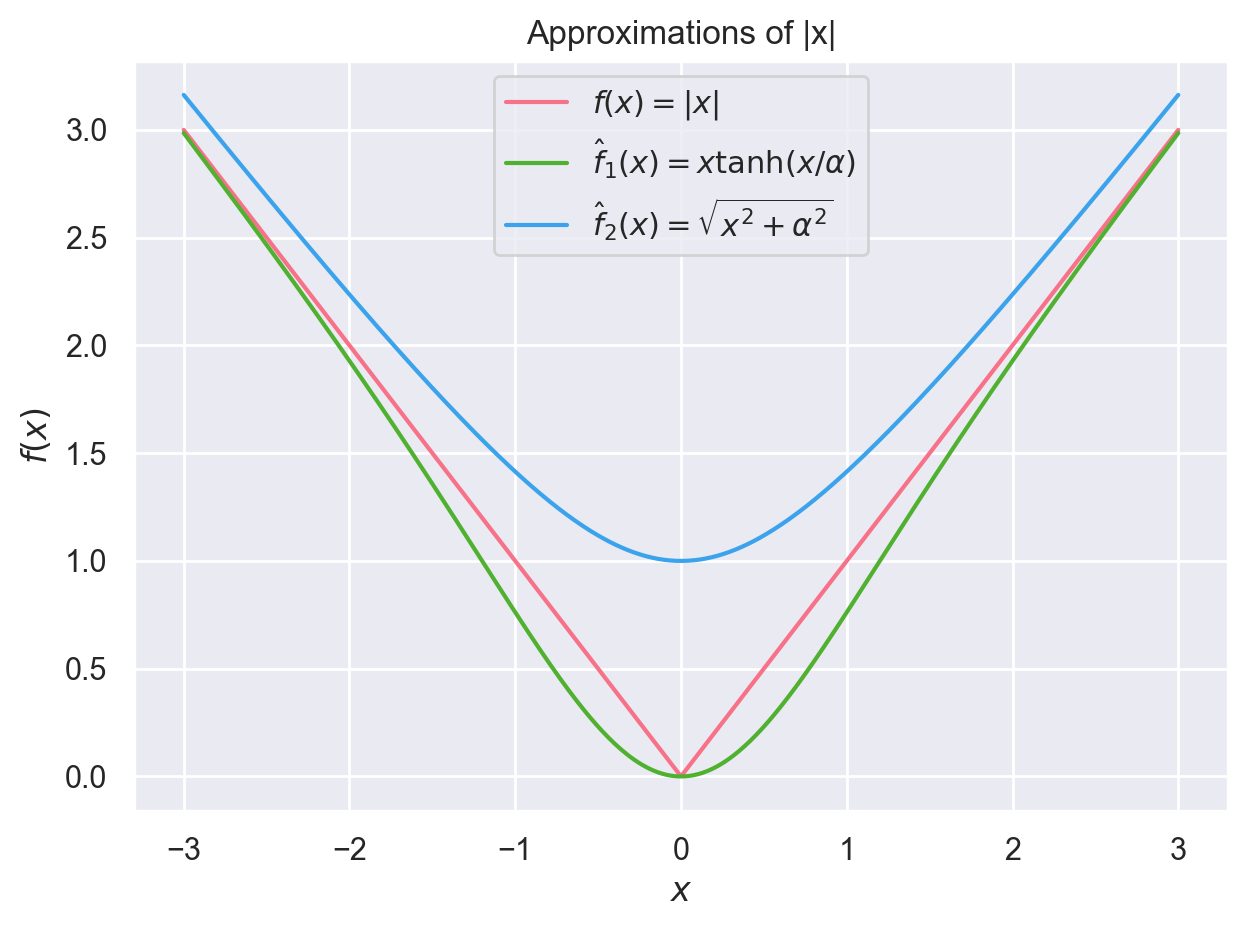

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette=sns.color_palette("husl", 3))
import aerosandbox.numpy as np

x = np.linspace(-3, 3, 500)
alpha = 1

f = np.fabs(x)
f_hat_1 = x * np.tanh(x / alpha)
f_hat_2 = np.sqrt(x ** 2 + alpha ** 2)

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
plt.plot(x, f, label="$f(x) = |x|$")
plt.plot(x, f_hat_1, label = r"$\hat{f}_1(x) = x \tanh(x / \alpha)$")
plt.plot(x, f_hat_2, label = r"$\hat{f}_2(x) = \sqrt{x^2 + \alpha^2}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.title(r"Approximations of |x|")
plt.tight_layout()
plt.legend()
plt.show()

Both of these approximations would solve just fine if we gave it to the optimizer. (Try it yourself and see!)

So which one should we use? Generally, the second one - let's look at the approximators to see why:

#### 1. $\hat{f}_1(x) = x \tanh(x / \alpha)$

This approximator has the advantage that the function value at the minimum is unchanged. So, if you expect the minimum to be there, you might get a more accurate answer.

However, $\hat{f}_1$ is a nonconvex function (in simple terms, and because $\hat{f}_1$ is continuous, this means the second derivative $\hat{f}_1''$ is not greater than or equal to zero everywhere). Nonconvexity is a bad thing, because it means we can no longer guarantee global optimality upon subsequent arbitrary convex transformations of the function.

Imagine if, instead of directly minimizing $\hat{f}_1(x)$, this was simply a piece of a larger optimization problem. Say, for example, we were instead minimizing $|x| + 0.02x^2 - 1.2x$. This problem turns out to be *unimodal* at $(5, -0.5)$, which means that there is only one local minimum and it is the global minimum. Because the function we're minimizing is convex, we know that it is either unimodal or unbounded.

Now imagine we instead used our approximation for $|x|$ with the smoothing parameter $\alpha = 1$ to get rid of the discontinuity, giving $x \tanh{x} + 0.02 x ^ 2 - 1.2 x$. This turns out to be *multimodal* at both (0.926, -0.419) and (4.979, -0.5)$ - there are multiple local minima. Of course, the optimizer will only give you one of these (IPOPT is a local optimizer, like all other practical optimizers suitable for general nonconvex problems that are even remotely high-dimensional), and it's effectively impossible to know which one you'll get until you run the algorithm.

Let's look at our other approximator.

#### 2. $\hat{f}_2(x) = \sqrt{x^2 + \alpha^2}$

This approximator doesn't preserve the function value at the minimum, but it does have two huge advantages that more than make up for this:
1. It is convex, and thus preserves global optimality guarantees upon further convex transformation.
2. It more accurately represents the gradient of the function, which ise critical for optimizer success and stability.

**Because of this, this second approximator is much better for optimization purposes, and it's the one you should use.**

Now, we've had a lot of talk in this subsection about convexity and its importance for unimodality - let's illustrate what we mean by that, using the same example described above. Note that the first approximation results in a multimodal design space, while the second approximation keeps the design space unimodal.

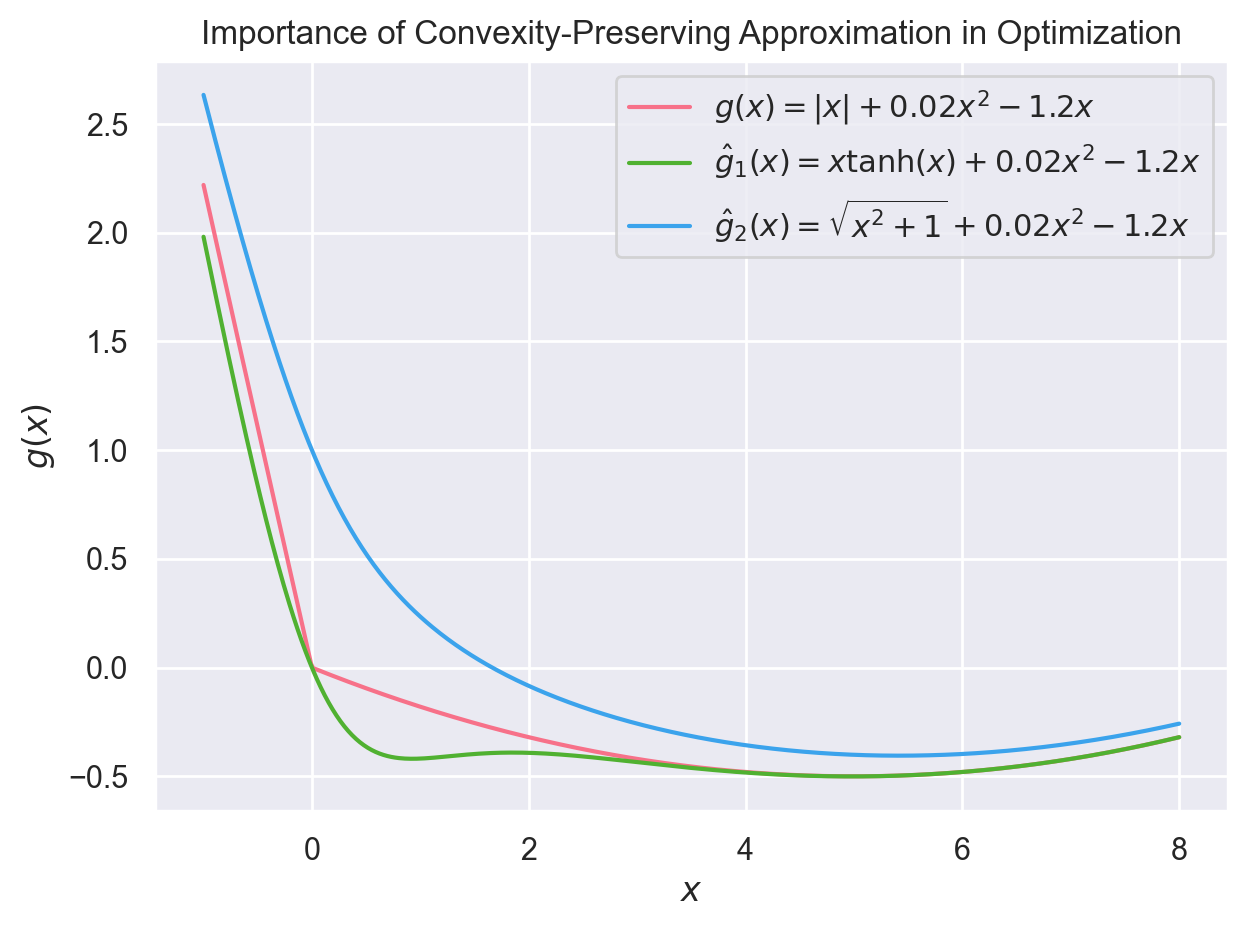

In [7]:
x = np.linspace(-1, 8, 500)

convex_modification = 0.02 * x ** 2 - 1.2 * x
g = np.fabs(x) + convex_modification
g_hat_1 = x * np.tanh(x) + convex_modification
g_hat_2 = np.sqrt(x**2 + 1) + convex_modification

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
plt.plot(x, g, label = r"$g(x) = |x| + 0.02x^2 - 1.2x$")
plt.plot(x, g_hat_1, label = r"$\hat{g}_1(x) = x \tanh(x) + 0.02 x ^2 - 1.2x$")
plt.plot(x, g_hat_2, label = r"$\hat{g}_2(x) = \sqrt{x^2+1} + 0.02 x ^2 - 1.2x$")
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Importance of Convexity-Preserving Approximation in Optimization")
plt.tight_layout()
plt.legend()
plt.show()

Of course, $|x|$ is far from the only discontinuous function that we'd ever want to optimize, and coming up with these continuous approximators for each individual function would be quite tedious. So, `aerosandbox` has a few tools that can automatically find these continuous approximators for you - keep reading for more details! (See "Generalized Methods to Fix Discontinuities")

## Other Functions that Often Lead to Discontinuities

Let's talk about a couple of other commonly-used nonlinear functions that often lead to discontinuities. For the most part, issues with these are fixed in the same way that we described above.

1. Maximum: `np.fmax(x, y)`. This function compares the values of $x$ and $y$ and returns the maximum of them. (If $x$ and $y$ are vectors, this function works element-wise.) As you can imagine, this function can easily be discontinuous with respect to changes in $x$ and $y$ - as an example, imagine `np.fmax(x, 0)`, and note that it's not differentiable at $x=0$. Also, note that `np.fmax(x, -x)` is identical to the absolute value function, and we've already shown that $|x|$ is discontinuous.

2. Minimum: `np.fmin(x, y)`. This function compares the values of $x$ and $y$ and returns the minimum of them. (If $x$ and $y$ are vectors, this function works element-wise.) Same considerations as above apply.

3. If-Else, also called Where: `np.where(condition, value_if_true, value_if_false)`. This function looks at the value of a condition and returns one value if true and another value if false. All three arguments can be scalars, or they can be vectors, in which case this function works element-wise. Unless the two functions `value_if_true` and `value_if_false` are $C_1$-continuous at all points where they "switch over" based on the `condition`, this will result in a discontinuity.

## Generalized Methods to Fix Discontinuities

In our $|x|$ example above, we demonstrated two possible ways to approximate a discontinuous function with a continuous one. There, we implemented functions specific to $|x|$ - but here, we can be a bit more general.

### Softmax

For convex functions, we can use a function called softmax or logsumexp (depending on which field you're in) as a replacement for the $\max()$ function.

Softmax is defined as the following:

$\max(x, y) \approx \text{softmax}(x, y) = \ln(e^x+e^y)$

You can read more about softmax here: https://www.johndcook.com/soft_maximum.pdf

In AeroSandbox, we can use the syntax `np.softmax(x, y)` to accomplish this. `np.softmax` also takes an optional third parameter, `hardness`, which controls how "soft" our softmax is (higher values make the function closer to $\max(x,y)$).

For example, you could represent $|x|$ as:

In [8]:
abs_x = np.softmax(x, -x)

Note that softmax **preserves convexity**.

### Blend

For general nonconvex functions, you can use the AeroSandbox function `blend`. As the name implies, `blend` blends between two functions based on some value of a switching parameter. It uses identical syntax to `np.where`, so it's syntax is `blend(switch, value_switch_high, value_switch_low)`. Hardness can be controlled by multiplying the switch value by a constant.

For example, you could represent $|x|$ as:

In [9]:
abs_x = np.blend(x, x, -x)

When `x` is strongly positive, `x` is returned. When `x` is strongly negative, `-x` is returned.

Note that blend **does not necessarily preserve convexity**.